In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling, plotting

from matplotlib import cm
import pickle
import logomaker

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]

In [3]:
experiment_id_idx = 2
experiment_id = experiment_ids[experiment_id_idx]

In [4]:
model = torch.load(f'saved/{experiment_id}_wd_0.1.pt', weights_only=False, map_location='cpu')

In [5]:
sequences, sequences_unique, counts, log_multinomial_factors = utils.sequences_counts_from_files(experiment_id, round_ids)

Finished round ARN
Finished round R01
Finished round R02N


In [6]:
sequences_unique_all, counts_unique = utils.group_rounds(sequences, sequences_unique, counts)

Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
Finished


In [7]:
train_valid_idx = torch.load(f'saved/train_test_split/{experiment_id}.pt')
idx_train = train_valid_idx['idx_train']
idx_valid = train_valid_idx['idx_valid']

In [8]:
((sequences_oh, total_reads, log_multinomial_factors), 
 (sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)) = \
    data_loading.split_train_test(sequences_unique_all, counts_unique, idx_train, idx_valid)

In [9]:
sequences_unique_valid_oh = utils.one_hot(sequences_unique_all[idx_valid])

In [10]:
sequences_oh = [utils.one_hot(s) for s in sequences]
total_reads = torch.tensor([len(s) for s in sequences])

In [11]:
model_indep = torch.load(f'saved/{experiment_id}_indep_sites.pt', weights_only=False, map_location='cpu')

In [12]:
def log_likelihood_indep_sites(model_indep, sequences_oh, total_reads, log_multinomial_factors):
    models_t = [energy_models.IndepSites(model_indep.round_zero.h + t * model_indep.selection.modes[0].h) for t in range(model_indep.get_n_rounds())]
    log_likelihood_normaliz = total_reads.sum().item()
    
    log_likelihood = 0.0
    for t in range(model_indep.get_n_rounds()):
        Lt = models_t[t].log_prob(sequences_oh[t]).mean()
        log_likelihood += (log_multinomial_factors[t] + total_reads[t] * Lt).item()
    
    return log_likelihood / log_likelihood_normaliz

In [13]:
nll_indep = - log_likelihood_indep_sites(model_indep, sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)
nll_indep

25.66418664431322

In [14]:
n_chains = 10**3
n_sweeps = 1
step = 1e-4

In [15]:
def estimate_nll_potts(sequences_oh, model, total_reads, log_multinomial_factors, n_chains, n_sweeps, step):
    batches = sequences_oh
    nll_potts = - training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
    return nll_potts

In [16]:
weight_decays = [0.0, 1e-2, 1e-1, 1e0]

models_potts = []
for weight_decay in weight_decays:
    model = torch.load(f'saved/{experiment_id}_wd_{weight_decay}_init.pt', weights_only=False, map_location='cpu')
    models_potts.append(model)

In [17]:
nll_potts = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh, model, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)
    nll_potts.append(nll)

nll_potts

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[25.568239212036133, 25.51617431640625, 25.608821868896484, 25.650156021118164]

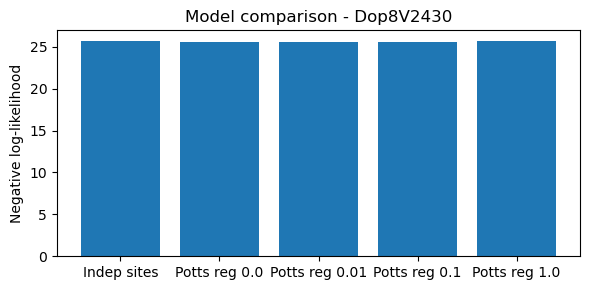

In [18]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls = [nll_indep] + nll_potts
ax.bar(ticks, nlls)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id}')
plt.tight_layout()

## Looking around wildtype

In [19]:
model = models_potts[1]

In [20]:
with open('./saved/wildtypes_sites.pkl', 'rb') as f:
    wts = pickle.load(f)

wt = wts[experiment_id_idx]
wt_oh = utils.one_hot(wt)
L = 45
q = 4

In [21]:
def hamming(x, y):
    L = x.size(-1)
    return (x != y).sum(dim=(-1))

In [22]:
def sequences_at_distance_1(wt):
    seq = []
    for i in range(L):
        delta = torch.zeros(L)
        # use itertools.product here to generalize to distance d
        for a in range(1, q):
            delta[i] = a
            s = torch.fmod(delta+wt, q)
            seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 1)
    return neigs

def sequences_at_distance_2(wt):
    seq = []
    for i in range(L):
        for j in range(L):
            if j != i:
                delta = torch.zeros(L)
                for a in range(1, q):
                    delta[i] = a
                    for b in range(1, q):
                        delta[j] = b
                        s = torch.fmod(delta+wt, q)
                        seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 2)
    return neigs

def sequences_at_distance_3(wt):
    seq = []
    for i in range(L):
        for j in range(L):
            for k in range(L):
                if j != i and j != k and i != k:
                    delta = torch.zeros(L)
                    for a in range(1, q):
                        delta[i] = a
                        for b in range(1, q):
                            delta[j] = b
                            for c in range(1, q):
                                delta[k] = c
                                s = torch.fmod(delta+wt, q)
                                seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 3)
    return neigs

In [23]:
def plot_hist(model, wt, neigs, **kwargs):
    neighbors_oh = utils.one_hot(neigs)
    logps_neigs = - model.selection_energy_at_round(neighbors_oh, 1).detach()
    logps_wt = - model.selection_energy_at_round(wt_oh, 1).detach()
    fig, ax = plt.subplots(**kwargs)
    ax.hist(logps_neigs, bins=100, density=True)
    ax.axvline(x=logps_wt.item(), color='red', label="wildtype")
    ax.set_xlabel('logps'); ax.set_ylabel('frequency')
    ax.legend()
    return logps_neigs, logps_wt, fig, ax

In [24]:
def best_mutations(model, wt, neigs):
    neighbors_oh = utils.one_hot(neigs)
    logps_neigs = - model.selection_energy_at_round(neighbors_oh, 1).detach()
    logps_wt = - model.selection_energy_at_round(wt_oh, 1).detach()
    idx_best = logps_neigs >= logps_wt
    logps_best = (logps_neigs - logps_wt)[idx_best]
    perm = torch.argsort(logps_best)
    return torch.argmax(neighbors_oh[idx_best], dim=-1), perm, logps_best

In [25]:
neighbors_1 = sequences_at_distance_1(wt)
neighbors_2 = sequences_at_distance_2(wt)
neighbors_3 = sequences_at_distance_3(wt)

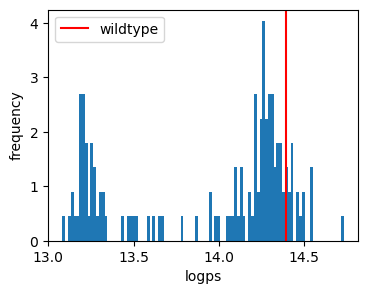

In [26]:
plot_hist(model, wt, neighbors_1, figsize=(4,3))
ax.set_title('Neighbors at distance 1 - potts');

In [27]:
best_1_mutations_potts, perm_1_potts, logps_best_1_potts = best_mutations(model, wt, neighbors_1)

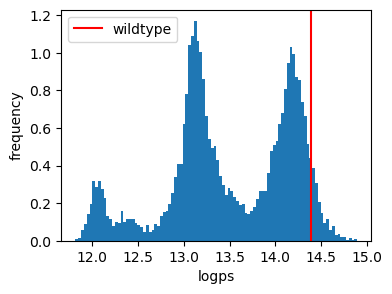

In [28]:
plot_hist(model, wt, neighbors_2, figsize=(4,3))
ax.set_title('Neighbors at distance 2 - potts');

In [29]:
best_2_mutations_potts, perm_2_potts, logps_best_2_potts = best_mutations(model, wt, neighbors_2)

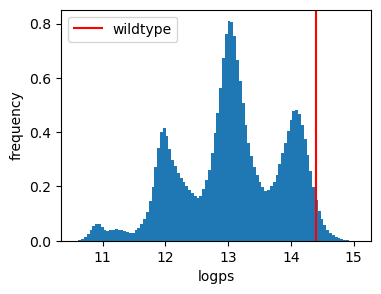

In [30]:
plot_hist(model, wt, neighbors_3, figsize=(4,3))
ax.set_title('Neighbors at distance 3 - potts');

In [31]:
best_3_mutations_potts, perm_3_potts, logps_best_3_potts = best_mutations(model, wt, neighbors_3)

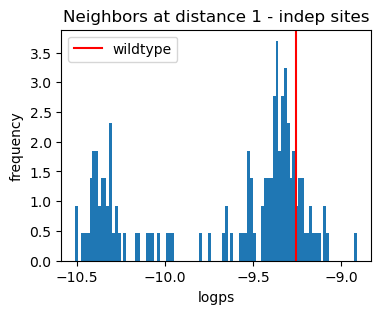

In [32]:
logps_neigs_1_indep, logps_wt_1_indep, fig, ax = plot_hist(model_indep, wt, neighbors_1, figsize=(4,3))
ax.set_title('Neighbors at distance 1 - indep sites');

In [33]:
best_1_mutations_indep, perm_1_indep, logps_best_1_indep = best_mutations(model_indep, wt, neighbors_1)

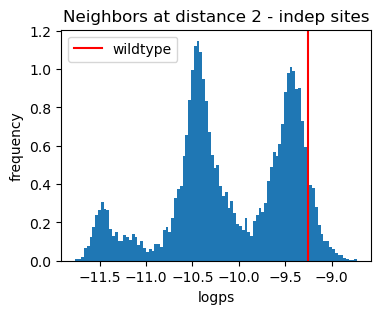

In [34]:
logps_neigs_1_indep, logps_wt_1_indep, fig, ax = plot_hist(model_indep, wt, neighbors_2, figsize=(4,3))
ax.set_title('Neighbors at distance 2 - indep sites');

In [35]:
best_2_mutations_indep, perm_2_indep, logps_best_2_indep = best_mutations(model_indep, wt, neighbors_2)

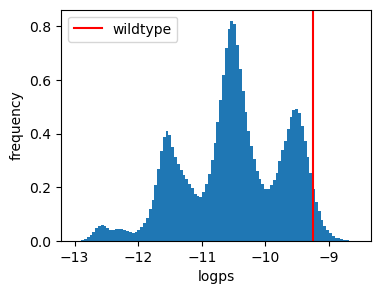

In [36]:
plot_hist(model_indep, wt, neighbors_3, figsize=(4,3))
ax.set_title('Neighbors at distance 3 - indep sites');

In [37]:
best_3_mutations_indep, perm_3_indep, logps_best_3_indep = best_mutations(model_indep, wt, neighbors_3)

### Compare best mutations

In [38]:
from IPython.core.display import HTML as print_html

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def red_at_index(seq, idx=None):
    red = "\033[31m"
    green = "\033[32m"
    blue = "\033[34m"
    reset = "\033[39m"
    if isinstance(idx, int):
        idx = [idx]
    elif idx is None:
        idx = []
    letters = [utils.TOKENS_DNA[s] for s in seq]
    letters_colored = []
    for a in range(len(letters)):
        l = letters[a]
        if a in idx:
            letters_colored.append(red+l+reset)
        else:
            letters_colored.append(l)
    return ''.join(letters_colored)

def highlight_mutation_and_print(seq, idx=None):
    s = red_at_index(seq, idx=idx)
    print(s)
    return s

In [39]:
mutation_idx = [(best_1_mutations_indep[i] != wt).nonzero().item() for i in range(best_1_mutations_indep.size(0))]
wt_letters = [utils.TOKENS_DNA[wt[idx].item()] for (i, idx) in enumerate(mutation_idx)]
mutation_ints = [best_1_mutations_indep[i][idx].item() for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [utils.TOKENS_DNA[a] for a in mutation_ints]
mutation_idx_unique_1_indep = torch.unique(torch.tensor(mutation_idx))
print('1 SITE - INDEP SITES')
mutations_1_indep = list(zip(mutation_idx, wt_letters, mutation_letters))

highlight_mutation_and_print(wt)
for (idx, a) in zip(mutation_idx, mutation_ints):
    x = wt.clone()
    x[idx] = a
    highlight_mutation_and_print(x, idx)

1 SITE - INDEP SITES
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGAGGACCATGCCA
CGAGTTGAGATGTCGGCCCACAGCTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCTCAGCTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCAAAGCTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACGGCTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGGTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGATAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCGAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTTACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTACCGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACTGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGTTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGATCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGCTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGACGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCCAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGATGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGACGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGAGGACTATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGAGGACCCTGCCA


In [40]:
mutation_idx = [(best_1_mutations_potts[i] != wt).nonzero().item() for i in range(best_1_mutations_potts.size(0))]
wt_letters = [utils.TOKENS_DNA[wt[idx].item()] for (i, idx) in enumerate(mutation_idx)]
mutation_ints = [best_1_mutations_potts[i][idx].item() for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [utils.TOKENS_DNA[a] for a in mutation_ints]
print('1 SITE - POTTS')
mutations_1_potts = list(zip(mutation_idx, wt_letters, mutation_letters))

highlight_mutation_and_print(wt)
for (idx, a) in zip(mutation_idx, mutation_ints):
    x = wt.clone()
    x[idx] = a
    highlight_mutation_and_print(x, idx)

1 SITE - POTTS
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGAGGACCATGCCA
CGAGTTGAGATGTCGGCCCACAGCTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCTCAGCTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCAAAGCTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACGGCTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGGTAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGATAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCGAACGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTACCGGTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGTTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGATCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGCTCGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGACGAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCCAGGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGATGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGACGACCATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGAGGACTATGCCA
CGAGATGAGATGTCGGCCCACAGCTAACGGTCGAGGACCCTGCCA


In [41]:
print('Good 1-mutations according to Potts that are not good according to Indep Sites:')

for m in mutations_1_potts:
    if m not in mutations_1_indep:
        print(m)

Good 1-mutations according to Potts that are not good according to Indep Sites:


In [42]:
mutation_idx = [tuple((best_2_mutations_indep[i] != wt).nonzero().squeeze().tolist()) for i in range(best_2_mutations_indep.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_2_mutations_indep[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('2 SITE - INDEP SITES')
mutations_2_indep = list(zip(mutation_idx, wt_letters, mutation_letters))
len(mutations_2_indep)

2 SITE - INDEP SITES


1138

In [43]:
mutation_idx = [tuple((best_2_mutations_potts[i] != wt).nonzero().squeeze().tolist()) for i in range(best_2_mutations_potts.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_2_mutations_potts[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('2 SITE - POTTS')
mutations_2_potts = list(zip(mutation_idx, wt_letters, mutation_letters))
len(mutations_2_potts)

2 SITE - POTTS


926

In [44]:
print('Good 2-mutations according to Potts that are not good according to Indep Sites:')

for m in mutations_2_potts:
    if m not in mutations_2_indep:
        print(m)

Good 2-mutations according to Potts that are not good according to Indep Sites:
((18, 19), ('C', 'A'), ['A', 'T'])
((18, 29), ('C', 'G'), ['T', 'A'])
((18, 34), ('C', 'G'), ['A', 'T'])
((18, 19), ('C', 'A'), ['A', 'T'])
((18, 29), ('C', 'G'), ['T', 'A'])
((18, 34), ('C', 'G'), ['A', 'T'])


In [45]:
double_good_mutations_indep = []

for m in mutations_2_indep:
    i, j = m[0]
    if (i in mutation_idx_unique_1_indep) and (j in mutation_idx_unique_1_indep):
        double_good_mutations_indep.append(m)
print(f'Indep Sites: {len(double_good_mutations_indep)} good 2-mutations out of {len(mutations_2_indep)} are the sum of two good 1-mutations')

Indep Sites: 722 good 2-mutations out of 1138 are the sum of two good 1-mutations


In [46]:
print('Good 2-mutations (both good) according to Indep Sites that are not good according to Potts:')

for m in double_good_mutations_indep:
    if m not in mutations_2_potts:
        print(m)

Good 2-mutations (both good) according to Indep Sites that are not good according to Potts:
((19, 21), ('A', 'A'), ['C', 'G'])
((19, 21), ('A', 'A'), ['G', 'G'])
((19, 23), ('A', 'C'), ['C', 'G'])
((19, 23), ('A', 'C'), ['G', 'G'])
((19, 25), ('A', 'A'), ['T', 'G'])
((19, 29), ('A', 'G'), ['C', 'C'])
((19, 29), ('A', 'G'), ['G', 'C'])
((19, 34), ('A', 'G'), ['T', 'A'])
((20, 21), ('C', 'A'), ['T', 'G'])
((20, 23), ('C', 'C'), ['T', 'G'])
((20, 24), ('C', 'T'), ['G', 'G'])
((20, 24), ('C', 'T'), ['A', 'A'])
((20, 28), ('C', 'G'), ['A', 'C'])
((20, 29), ('C', 'G'), ['T', 'C'])
((19, 21), ('A', 'A'), ['C', 'G'])
((19, 21), ('A', 'A'), ['G', 'G'])
((20, 21), ('C', 'A'), ['T', 'G'])
((21, 24), ('A', 'T'), ['G', 'C'])
((21, 24), ('A', 'T'), ['T', 'G'])
((21, 29), ('A', 'G'), ['C', 'A'])
((21, 32), ('A', 'G'), ['C', 'C'])
((21, 38), ('A', 'C'), ['G', 'G'])
((19, 23), ('A', 'C'), ['C', 'G'])
((19, 23), ('A', 'C'), ['G', 'G'])
((20, 23), ('C', 'C'), ['T', 'G'])
((23, 26), ('C', 'A'), ['A', 'G']

In [47]:
mutation_idx = [tuple((best_3_mutations_indep[i] != wt).nonzero().squeeze().tolist()) for i in range(best_3_mutations_indep.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_3_mutations_indep[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('3 SITE - INDEP SITES')
mutations_3_indep = list(zip(mutation_idx, wt_letters, mutation_letters))
len(mutations_3_indep)

3 SITE - INDEP SITES


67626

In [48]:
mutation_idx = [tuple((best_3_mutations_potts[i] != wt).nonzero().squeeze().tolist()) for i in range(best_3_mutations_potts.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_3_mutations_potts[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('3 SITE - POTTS')
mutations_3_potts = list(zip(mutation_idx, wt_letters, mutation_letters))
len(mutations_3_potts)

3 SITE - POTTS


49950

## NLL at distances

In [49]:
hamming_all = hamming(wt, sequences_unique_all)
# idx_valid_distances = [(hamming_valid == 1).nonzero(), (hamming_valid == 2).nonzero()]
idx_valid_bool = torch.zeros(len(sequences_unique_all), dtype=bool)
idx_valid_bool[idx_valid] = 1
idx_valid_1 = ((hamming_all == 1) * idx_valid_bool).nonzero().squeeze()
idx_valid_2 = ((hamming_all == 2) * idx_valid_bool).nonzero().squeeze()
idx_valid_3 = ((hamming_all == 3) * idx_valid_bool).nonzero().squeeze()
# neighbors_valid_oh_1 = utils.one_hot(sequences_unique_all[idx_valid_1])
# neighbors_valid_oh_2 = utils.one_hot(sequences_unique_all[idx_valid_2])
# neighbors_valid_oh_3 = utils.one_hot(sequences_unique_all[idx_valid_3])

In [50]:
len(idx_valid_1), len(idx_valid_2), len(idx_valid_3)

(14, 9, 6)

In [51]:
sequences_valid_oh_1, total_reads_valid_1, log_multinomial_factors_valid_1 = utils.subsample_sequences(sequences_unique_all, counts_unique, idx_valid_1)
sequences_valid_oh_2, total_reads_valid_2, log_multinomial_factors_valid_2 = utils.subsample_sequences(sequences_unique_all, counts_unique, idx_valid_2)
sequences_valid_oh_3, total_reads_valid_3, log_multinomial_factors_valid_3 = utils.subsample_sequences(sequences_unique_all, counts_unique, idx_valid_3)

In [52]:
nll_indep_1 = - log_likelihood_indep_sites(model_indep, sequences_valid_oh_1, total_reads_valid_1, log_multinomial_factors_valid_1)
nll_indep_1

11.103850186942315

In [53]:
nll_indep_2 = - log_likelihood_indep_sites(model_indep, sequences_valid_oh_2, total_reads_valid_2, log_multinomial_factors_valid_2)
nll_indep_2

14.015171959286643

In [54]:
total_reads_valid_3, log_multinomial_factors_valid_3

(tensor([ 8,  0, 25]), tensor([ 9.2183,  0.0000, 10.8317]))

In [55]:
nll_indep_3 = - log_likelihood_indep_sites(model_indep, sequences_valid_oh_3, total_reads_valid_3, log_multinomial_factors_valid_3)
nll_indep_3

nan

In [56]:
n_chains = 10**3
n_sweeps = 1
step = 1e-4

In [57]:
def estimate_nll_potts(sequences_oh, model, total_reads, log_multinomial_factors, n_chains, n_sweeps, step):
    batches = sequences_oh
    nll_potts = - training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
    return nll_potts

In [58]:
weight_decays = [0.0, 1e-2, 1e-1, 1e0]

models_potts = []
for weight_decay in weight_decays:
    model = torch.load(f'saved/{experiment_id}_wd_{weight_decay}.pt', weights_only=False, map_location='cpu')
    models_potts.append(model)

In [59]:
nll_potts_1 = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh_1, model, total_reads_valid_1, log_multinomial_factors_valid_1, n_chains, n_sweeps, step)
    nll_potts_1.append(nll)

nll_potts_1

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[10.739558219909668, 10.850652694702148, 11.209517478942871, 11.4678373336792]

In [60]:
nll_potts_2 = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh_2, model, total_reads_valid_2, log_multinomial_factors_valid_2, n_chains, n_sweeps, step)
    nll_potts_2.append(nll)

nll_potts_2

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[13.786751747131348, 13.770263671875, 14.121771812438965, 14.325814247131348]

In [61]:
nll_potts_3 = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh_3, model, total_reads_valid_3, log_multinomial_factors_valid_3, n_chains, n_sweeps, step)
    nll_potts_3.append(nll)

nll_potts_3

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[nan, nan, nan, nan]

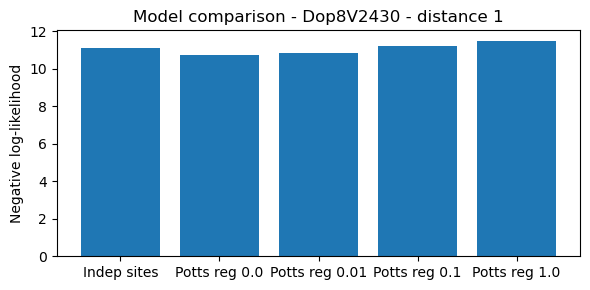

In [62]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls_1 = [nll_indep_1] + nll_potts_1
ax.bar(ticks, nlls_1)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id} - distance 1')
plt.tight_layout()

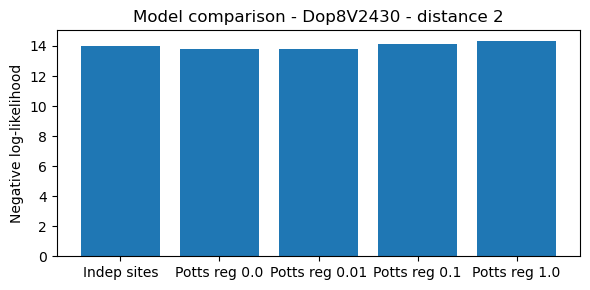

In [63]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls_2 = [nll_indep_2] + nll_potts_2
ax.bar(ticks, nlls_2)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id} - distance 2')
plt.tight_layout()

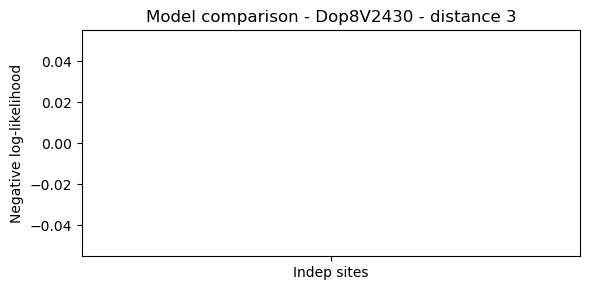

In [64]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls_3 = [nll_indep_3] + nll_potts_3
ax.bar(ticks, nlls_3)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id} - distance 3')
plt.tight_layout()

In [65]:
nlls = torch.stack([torch.tensor(nlls_1), torch.tensor(nlls_2), torch.tensor(nlls_3)])

Text(0, 0.5, 'difference in NLL wrt indep sites')

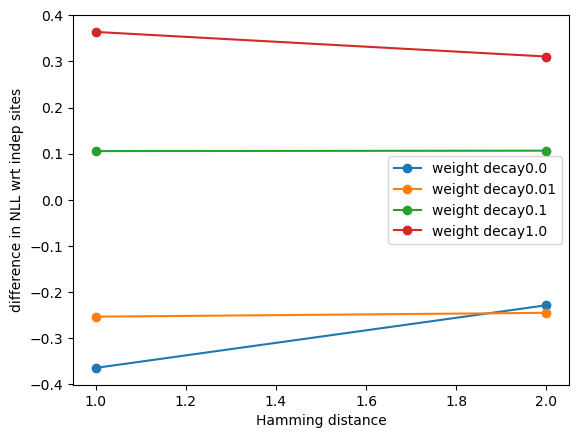

In [66]:
delta_nlls = nlls[:,1:] - nlls[:,0:1]
distances = [1,2,3]

fig, ax = plt.subplots()
ax.plot(distances, delta_nlls, marker='o', label=['weight decay' + str(w) for w in weight_decays])
ax.legend()
ax.set_xlabel('Hamming distance')
ax.set_ylabel('difference in NLL wrt indep sites')

## Look at parameters

Text(0.5, 1.0, 'Selection field for independent sites model')

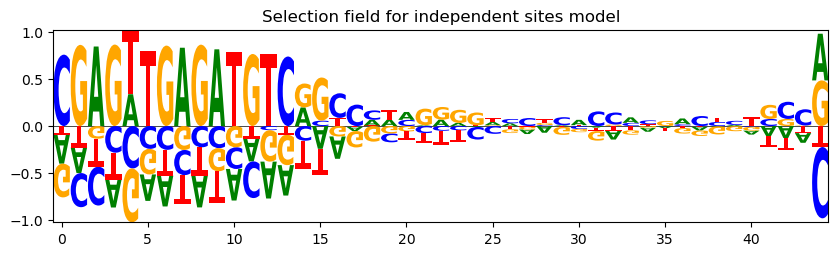

In [67]:
h_indep = model_indep.selection.modes[0].set_zerosum_gauge().h.clone().detach()
logomaker.Logo(pd.DataFrame(h_indep, columns=list(utils.TOKENS_DNA)))
plt.title('Selection field for independent sites model')

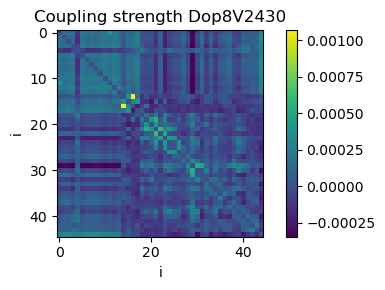

In [68]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge()
J = potts_zerosum.J.detach()

pl, ax = plt.subplots(figsize=(5,3))
F = torch.tensor(selex_dca.get_contact_map(J))
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
ax.set_title('Coupling strength ' + experiment_id)
plt.tight_layout();

In [69]:
def get_strongest_contact_indices(F, k):
    X = F.view(-1)
    L = F.size(1)
    _, indices = X.topk(2*k)
    idx = torch.cat(((indices // L).unsqueeze(1), (indices % L).unsqueeze(1)), dim=1)
    return idx[torch.arange(0, len(idx), 2)]

In [70]:
k = 10
get_strongest_contact_indices(F, k)

tensor([[16, 14],
        [22, 21],
        [19, 21],
        [29, 30],
        [22, 23],
        [31, 29],
        [24, 23],
        [20, 21],
        [24, 21],
        [ 0, 11]])

In [76]:
dtype = torch.float32
device = torch.device('cpu')

In [77]:
L, q = 45, 4
h = torch.randn(L, q, dtype=dtype)
k = torch.randn(L, q, dtype=dtype)
J = utils.rand_coupling_matrix(L, q, dtype=dtype)

In [83]:
potts = energy_models.Potts(J, h)
Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(energy_models.Potts(J, h+1/L), normalized=False)
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [84]:
X = sequences_oh[0][:1000]

In [89]:
logps_potts = - potts(X)*2

In [90]:
logps_model = - model.selection_energy_up_to_round(X, 2)

In [91]:
(logps_potts - (logps_model-2)).abs().max()

tensor(7.6294e-06, grad_fn=<MaxBackward1>)